In [1]:
source("/public/workspace/zhutao/scripts/colorpal.R")

In [ ]:
## This script is used for calculating OCRs and gene expression correlation.

library(GenomicRanges)
options(warn=-1)
library(BSDA)
library(foreach)

                      
gr.tss <- readRDS("/public/workspace/zhutao/encode/figure/fig3/input_df/tss_gr.rds")
peak_anno <- readRDS("/public/workspace/zhutao/encode/figure/fig3/nip_peak2gene/NIP_merged_peak_anno.rds")
peak_bed <- peak_anno
rownames(peak_bed) <-NULL
peak_gr <- makeGRangesFromDataFrame(peak_bed, keep.extra.columns=TRUE)
tss <- read.table("/public/workspace/zhutao/encode/figure/fig3/input_df/gene/nip_tss.bed", sep="\t", header=F, stringsAsFactors=F,row.names=4) 
atac_paired_norm <- readRDS("/public/workspace/zhutao/encode/figure/fig3/nip_peak2gene/NIP_ATAC_all_tissues_norm_quant_nonumi_paired.rds")
rna_paired <- readRDS("/public/workspace/zhutao/encode/figure/fig3/nip_peak2gene/NIP_RNA_all_tissues_norm_quant_paired.rds")

args = commandArgs(trailingOnly=TRUE)
gene<- args[1]
# Gene window
gr.bm_gs <- unique(gr.tss[gr.tss$gene %in% gene])
# Set max distance
start(gr.bm_gs) <- start(gr.bm_gs) - 100000
end(gr.bm_gs) <- end(gr.bm_gs) + 100000
ol <- findOverlaps(peak_gr, gr.bm_gs)
peak_in_window <- peak_gr[unique(from(ol))]
df <- data.frame(chr=seqnames(peak_in_window),
  start=start(peak_in_window),
  end=end(peak_in_window))
df$peak <- sprintf("chr%s:%s-%s", df$chr, df$start, df$end)
peak <- df$peak
n.cores <- 20
my.cluster <- parallel::makeCluster(
  n.cores, 
  type = "PSOCK"
  )
doParallel::registerDoParallel(cl = my.cluster)

p2g <- list()
for (i in 1:length(peak)){
    corr <- cor(as.matrix(atac_paired_norm)[peak[i],], rna_paired[gene,])
    test <- atac_paired_norm[!grepl(strsplit(peak[i], ":")[[1]][1], rownames(atac_paired_norm)),]
    set.seed(123)
    test_random <- test[sample(nrow(test), 10000), ]
    corr_random <- foreach(i = 1:10000,.combine = 'c') %dopar% {
   cor(as.matrix(test_random)[i,], rna_paired[gene,])
  }

test_res <- z.test(corr_random, mu=corr, sigma.x=15)
p2g[[i]] <- data.frame(peak=peak[i], gene=gene, cor=corr, p_value=test_res$p.value,category=peak_anno[peak[i],]$Type, 
                  tss=sprintf("%s:%s",tss[gene,]$V1,tss[gene,]$V2),summit2tss=tss[gene,]$V2 - peak_anno[peak[i],]$summit)
}
peak2gene_links <- do.call(rbind, p2g)
write.table(peak2gene_links,args[2],sep='\t',quote=F,row.names=F)

In [4]:
raw_p2g_new <- read.table("/public/workspace/zhutao/encode/figure/fig3/input_df/gene/all_peak2gene_final.txt")
p2g <- raw_p2g_new[raw_p2g_new$V3>=0.4 & abs(raw_p2g_new$V7)<= 20000,]
head(p2g)

,V1,V2,V3,V4,V5,V6,V7
,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<int>
39,chrSy:39081-39341,ChrSy.fgenesh.gene.12,0.4674062,0.003415713,distal,Sy:58993,19782
41,chrSy:44903-45158,ChrSy.fgenesh.gene.12,0.4667829,0.003461642,intra,Sy:58993,13963
43,chrSy:61644-62351,ChrSy.fgenesh.gene.12,0.4850587,0.002324488,intra,Sy:58993,-3004
44,chrSy:62718-63213,ChrSy.fgenesh.gene.12,0.4177861,0.009409245,intra,Sy:58993,-3972
45,chrSy:63368-63843,ChrSy.fgenesh.gene.12,0.4479467,0.005143825,intra,Sy:58993,-4612
46,chrSy:64165-64449,ChrSy.fgenesh.gene.12,0.4599053,0.004006997,distal,Sy:58993,-5314


In [5]:
table(p2g$V5)


  distal    intra promoter 
   21699     7435    18542 

In [8]:
length(unique(p2g$V2))
length(unique(raw_p2g_new$V2))
length(unique(p2g$V2)) / length(unique(raw_p2g_new$V2))

[1] 16576

[1] 29140

[1] 0.5688401

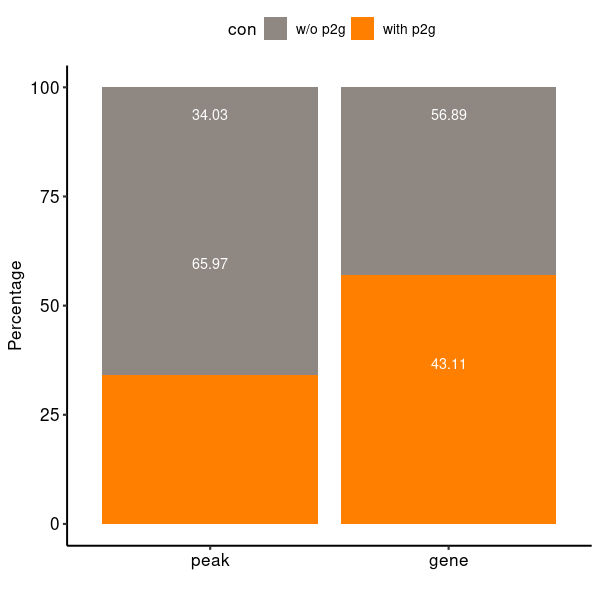

In [11]:
df <- data.frame(type=c("peak","peak", "gene","gene"),num=c(34.03,100-34.03, 56.89, 100 - 56.89),con=c("with p2g","w/o p2g", "with p2g","w/o p2g"))
library(plyr)
library(ggpubr)
df_sorted <- arrange(df, type, con) 
df2 <- ddply(df_sorted, "type",transform, label_ypos=cumsum(num))
library(ggplot2)
options(repr.plot.width = 6, repr.plot.height = 6, repr.plot.res = 100)
p1 <- ggplot(data=df2, aes(x=factor(type, levels=c("peak","gene")), y=num, fill=con)) +
  geom_bar(stat="identity")+geom_text(aes(y=label_ypos, label=num), vjust=3, 
            color="white", size=3.5)+theme_pubr() + scale_fill_manual(values = c("#8F8782", "#FF7F00"))+xlab("")+ylab("Percentage")
p1

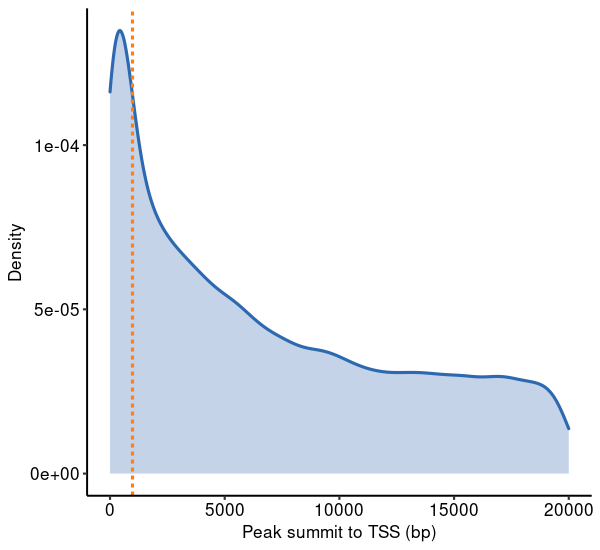

In [12]:
library(ggplot2)
library(ggpubr)
options(repr.plot.width = 6, repr.plot.height = 5.5, repr.plot.res = 100)
p2 <- ggplot(p2g, aes(x=abs(V7)))+
  geom_density(color="#2C69B0",fill="#B5C8E2",alpha=0.8,size=0.8)+theme_pubr()+
  xlab('Peak summit to TSS (bp)') +ylab("Density")+geom_vline(xintercept = 1000,linetype="dashed", size=0.8,color="#FF7F0E")
#annotate("text", x = 2500, y = 1.2, label = paste("<= 1 kb: ", 9935))
p2

Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”


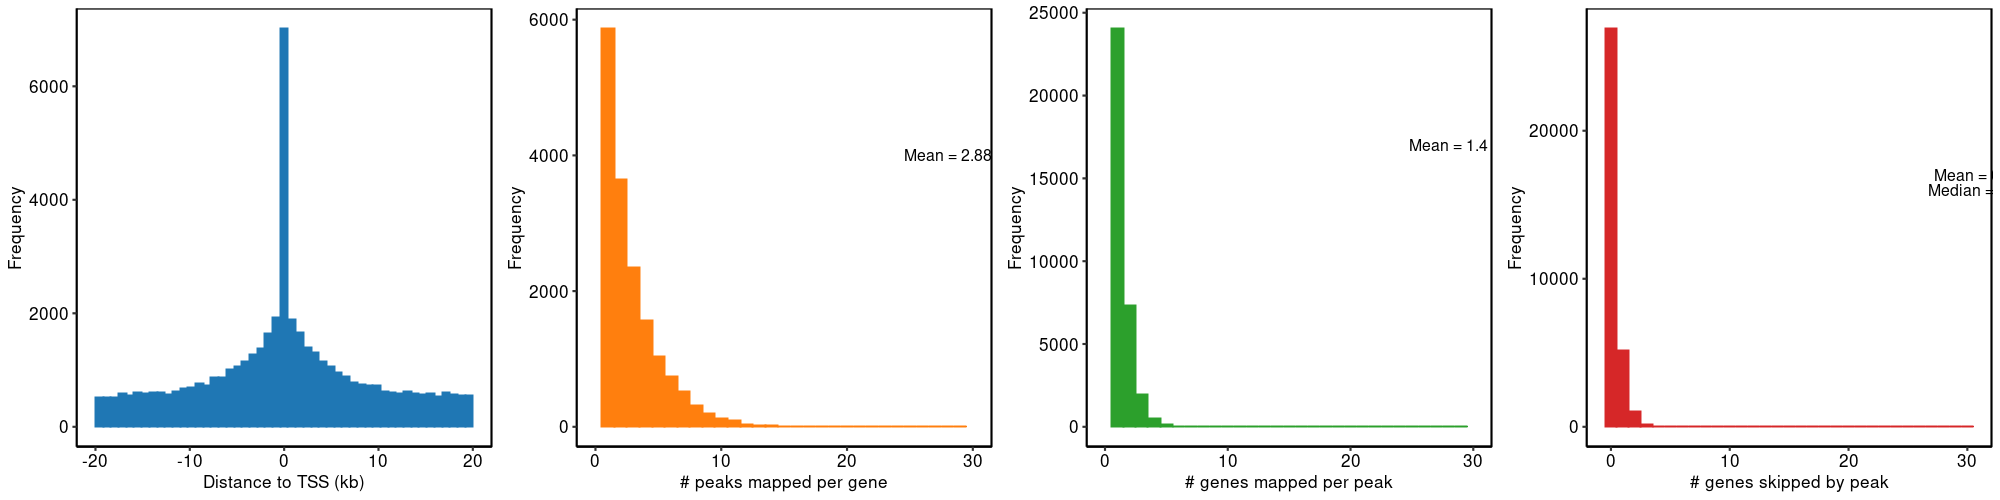

In [17]:
options(repr.plot.width = 20, repr.plot.height = 5, repr.plot.res = 100)
p3 <- ggplot(p2g, aes(x=V7/1000)) + geom_histogram(color="#1F77B4", fill="#1F77B4",bins = 50)+theme_pubr()+ 
  theme(panel.border = element_rect(colour = "black", fill=NA))+xlab('Distance to TSS (kb)') +ylab("Frequency")+
scale_x_continuous(limits = c(-20, 20))
library(ggplot2)
library(ggpubr)
p4 <- ggplot(data.frame(table(p2g$V2)), aes(x=Freq)) + geom_histogram(binwidth=1,color="#FF7F0E", fill="#FF7F0E")+theme_pubr()+ 
  theme(panel.border = element_rect(colour = "black", fill=NA))+xlab('# peaks mapped per gene') +ylab("Frequency")+
  annotate("text", x = 28, y = 4000, label = paste("Mean = ", round(mean(data.frame(table(p2g$V2))$Freq),2),sep=''))+
  scale_x_continuous(limits = c(0, 30))
p5 <- ggplot(data.frame(table(p2g$V1)), aes(x=Freq)) + geom_histogram(binwidth=1,color="#2CA02C", fill="#2CA02C")+theme_pubr()+ 
  theme(panel.border = element_rect(colour = "black", fill=NA))+xlab('# genes mapped per peak') +ylab("Frequency")+
  annotate("text", x = 28, y = 17000, label = paste("Mean = ", round(mean(data.frame(table(p2g$V1))$Freq),2),sep=''))+
  scale_x_continuous(limits = c(0, 30))
skip_gene <- read.table("/public/workspace/zhutao/encode/figure/fig3/p2g_skip_gene_num_10kb.txt")
p6 <- ggplot(skip_gene, aes(x=V5)) + geom_histogram(binwidth=1,color="#D62728", fill="#D62728")+theme_pubr()+ 
  theme(panel.border = element_rect(colour = "black", fill=NA))+xlab('# genes skipped by peak') +ylab("Frequency")+
  annotate("text", x =30, y = 17000, label = paste("Mean = ", round(mean(skip_gene$V5),0),sep=''))+
  annotate("text", x =30, y = 16000, label = paste("Median = ", round(median(skip_gene$V5),2),sep=''))
  #scale_x_continuous(limits = c(-0.1, 30))
print(ggarrange(p3,p4,p5,p6,ncol=4,nrow=1))

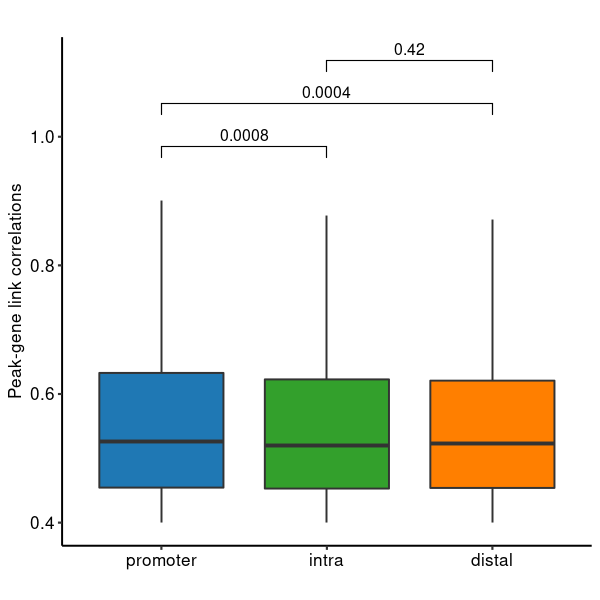

In [65]:
options(repr.plot.width = 6, repr.plot.height = 6, repr.plot.res = 100)
library(paletteer)
my_comparisons <- list(c("intra","promoter"), c("promoter","distal"),c("distal","intra"))
p7 <- ggplot(p2g, aes(x=factor(V5, levels = c("promoter","intra","distal")), y=V3, fill=V5)) +
          geom_boxplot(outlier.shape = NA) +scale_fill_manual(values= c(promoter="#1F78B4",intra="#33A02C",distal="#FF7F00"))+theme_pubr()+
          ylab('Peak-gene link correlations') +xlab("") +theme(legend.position = "none")+
          theme(legend.title = element_blank())+ggtitle("")  +theme(plot.title = element_text(hjust = 0.5))+
          stat_compare_means(comparisons = my_comparisons) 
p7

Loading required package: ggpp


Attaching package: ‘ggpp’


The following object is masked from ‘package:ggplot2’:

    annotate


`geom_smooth()` using formula 'y ~ x'



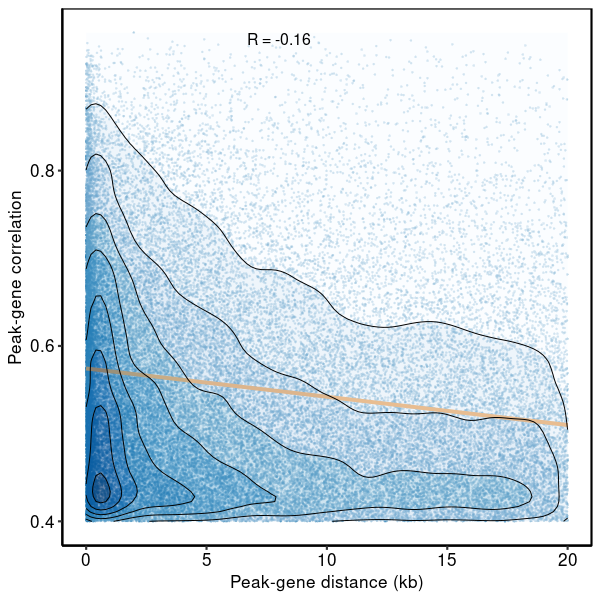

In [66]:
library(ggpmisc)
library(ggrastr)
p8 <- ggplot(p2g, aes(x=abs(V7)/1000, y=V3)) + 
        rasterise(geom_point(color="#1170AA",alpha=0.2,size=0.1), dpi=300)+
        geom_smooth(method=lm,color = "#F28E2B")+
        theme_pubr(legend = c("right"))+ theme(panel.border = element_rect(colour = "black", fill=NA))+
        xlab('Peak-gene distance (kb)') +ylab("Peak-gene correlation")+geom_density_2d_filled(alpha = 0.5) +
  geom_density_2d(size = 0.25, colour = "black")+scale_fill_brewer()+annotate("text", x = 8, y = 0.95, label = "R = -0.16")+theme(legend.position = "none")
p8

In [68]:
atac_paired_norm <- readRDS("/public/workspace/zhutao/encode/figure/fig3/input_df/ATAC_norm_quant.rds")
rna_paired <- readRDS("/public/workspace/zhutao/encode/figure/fig3/input_df/RNA_norm_quant.rds")
ss <- data.frame(ATAC=as.matrix(atac_paired_norm)["chr1:41688776-41690314",],RNA=rna_paired[c("LOC_Os01g71930"),])
ss$sample <- rownames(ss)
ss <- ss %>% separate(sample, c("Type", "Tissue"), "_")
plotPeakGene <- function(peak,gene){
    atac_paired_norm <- readRDS("/public/workspace/zhutao/encode/figure/fig3/input_df/ATAC_norm_quant.rds")
    rna_paired <- readRDS("/public/workspace/zhutao/encode/figure/fig3/input_df/RNA_norm_quant.rds")
    ss <- data.frame(ATAC=as.matrix(atac_paired_norm)[peak,],RNA=rna_paired[gene,])
    ss$sample <- rownames(ss)
    ss <- ss %>% separate(sample, c("Type", "Tissue"), "_")
    options(repr.plot.width = 6.5, repr.plot.height = 5, repr.plot.res = 100)
    pp <- ggplot(ss, aes(x=ATAC, y=RNA)) + 
        geom_point(aes(colour = Tissue,shape = Type))+
        geom_smooth(method=lm,color = "#F28E2B")+scale_color_manual(values=tissue_anno_col)+
        theme_pubr(legend = c("right"))+ theme(panel.border = element_rect(colour = "black", fill=NA))+
        xlab('ATAC-seq  log2(CPM+1)') +ylab("RNA-seq  log2(TPM+1)")+ggtitle(sprintf("%s\n%s", gene,peak))
 return(pp)
}

`geom_smooth()` using formula 'y ~ x'



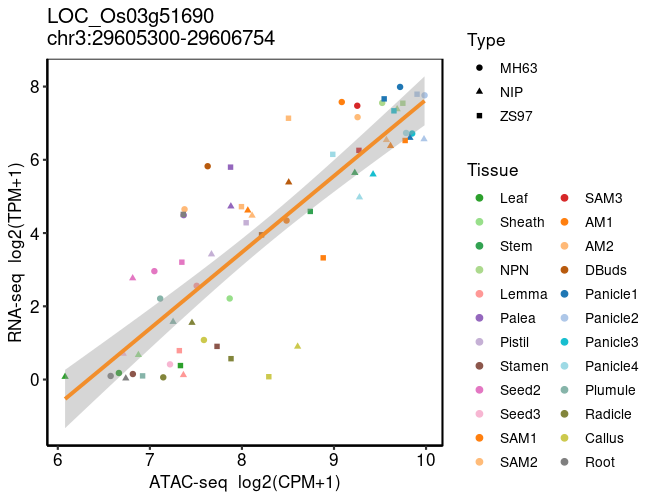

In [69]:
# OSH1
plotPeakGene("chr3:29605300-29606754","LOC_Os03g51690")

`geom_smooth()` using formula 'y ~ x'



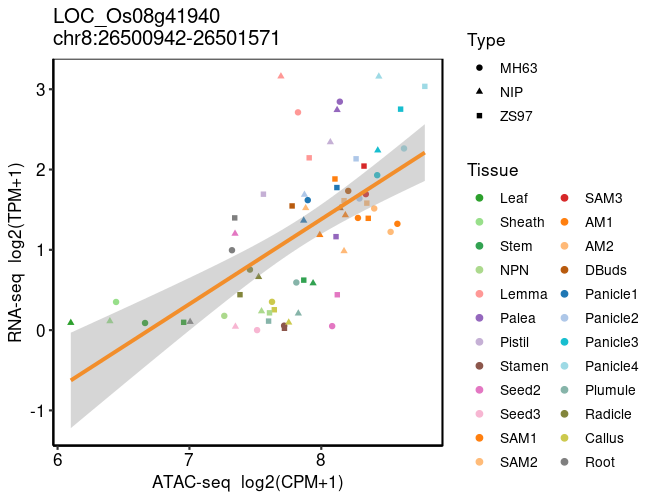

In [70]:
## GW8
plotPeakGene("chr8:26500942-26501571","LOC_Os08g41940")

In [73]:
nip <- read.table("/public/workspace/zhutao/encode/figure/fig3/tissue_sp_peak2gene/gene/all_gene_p2g.txt",head=T)
nip <- nip[abs(nip$summit2tss) <= 20000, ]
head(nip)

,peak,gene,cor,p_value,category,tss,summit2tss
,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<int>
23,chr1:88642-88982,LOC_Os01g01150,0.27300987,0.8544719,promoter,1:72775,-16037
27,chr1:88642-88982,LOC_Os01g01160,-0.11235599,0.9789314,promoter,1:82428,-6384
31,chr1:88642-88982,LOC_Os01g01170,0.02700661,0.9739448,promoter,1:85337,-3475
35,chr1:88642-88982,LOC_Os01g01180,-0.23767448,0.9089955,promoter,1:89204,392
39,chr1:88642-88982,LOC_Os01g01190,0.74612282,0.6335736,promoter,1:91521,2709
40,chr1:121266-121619,LOC_Os01g01280,0.43164557,0.7598209,intra,1:134291,12849


In [74]:
library(dplyr)
final_nip <- nip %>% group_by(peak) %>% top_n(1, cor) %>% as.data.frame()
final_nip <- final_nip[!duplicated(final_nip$peak),]
rownames(final_nip) <- gsub("chr","",final_nip$peak)
final_nip <- final_nip[final_nip$cor >= 0.4, ]
head(final_nip)

,peak,gene,cor,p_value,category,tss,summit2tss
,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<int>
1:88642-88982,chr1:88642-88982,LOC_Os01g01190,0.7461228,0.6335736,promoter,1:91521,2709
1:121266-121619,chr1:121266-121619,LOC_Os01g01280,0.4316456,0.7598209,intra,1:134291,12849
1:168518-170916,chr1:168518-170916,LOC_Os01g01350,0.4967552,0.7430330,intra,1:173434,3717
1:178085-178313,chr1:178085-178313,LOC_Os01g01390,0.7510804,0.6264507,distal,1:197647,19448
1:213866-214360,chr1:213866-214360,LOC_Os01g01430,0.4300807,0.7452820,distal,1:216126,2013
1:241027-241683,chr1:241027-241683,LOC_Os01g01470,0.6636729,0.6984599,intra,1:241641,286


In [76]:
length(unique(final_nip[final_nip$cor>=0.4, ]$peak))

[1] 6686

In [78]:
group <- read.table("/public/workspace/zhutao/encode/figure/fig3/6686_p2g_sp_peaks_cluster_group_PE.txt",row.names=1)
#rownames(group) <- group$V1
colnames(group) <- c("Cluster","Type")
group <- group[rownames(matr),]
group$Cluster <- factor(group$Cluster, levels = unique(group$Cluster))
head(group)

,Cluster,Type
,<fct>,<chr>
2:33926286-33927145,cluster1,Enhancer
10:13230575-13231087,cluster1,Enhancer
11:5582468-5582983,cluster1,Promoter
2:6250857-6251266,cluster1,Promoter
11:5588827-5589782,cluster1,Promoter
3:30349034-30349418,cluster1,Promoter


In [79]:
library(paletteer)
gcols <- setNames(as.character(paletteer_d("ggthemes::Tableau_20")),unique(group$Cluster))
gcols2 <- c("Promoter"="#00AFBB","Enhancer"="#FC4E07")
gcol <- list(Type=gcols2,Cluster=gcols)
gcol

$Type
 Promoter  Enhancer 
"#00AFBB" "#FC4E07" 

$Cluster
   cluster1    cluster2    cluster3    cluster4    cluster5    cluster6 
"#4E79A7FF" "#A0CBE8FF" "#F28E2BFF" "#FFBE7DFF" "#59A14FFF" "#8CD17DFF" 
   cluster7    cluster8    cluster9   cluster10   cluster11   cluster12 
"#B6992DFF" "#F1CE63FF" "#499894FF" "#86BCB6FF" "#E15759FF" "#FF9D9AFF" 
  cluster13   cluster14   cluster15   cluster16   cluster17   cluster18 
"#79706EFF" "#BAB0ACFF" "#D37295FF" "#FABFD2FF" "#B07AA1FF" "#D4A6C8FF" 
  cluster19   cluster20 
"#9D7660FF" "#D7B5A6FF"

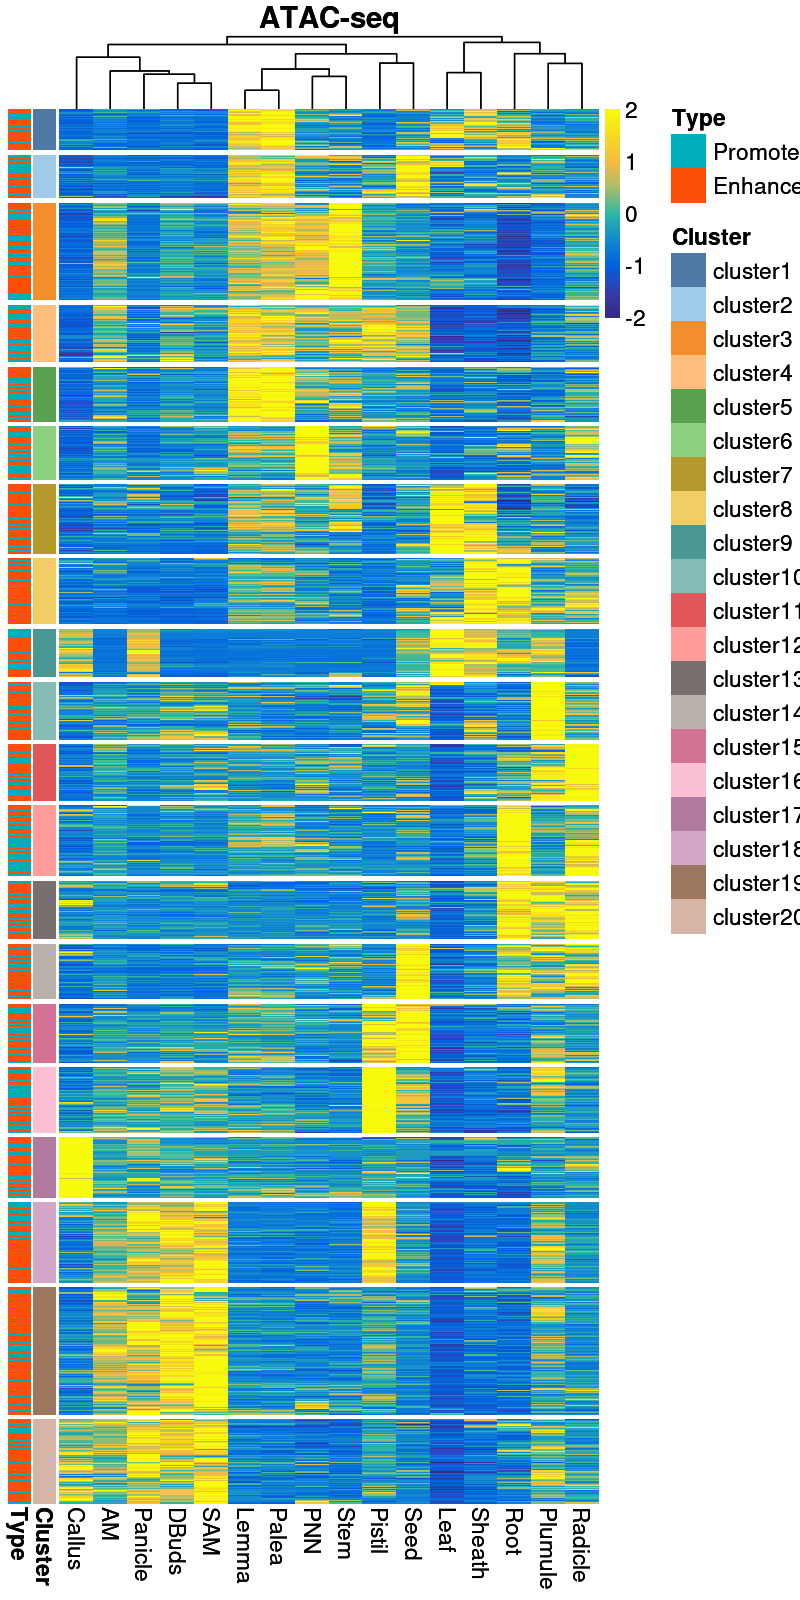

In [80]:
matr <- read.table("/public/workspace/zhutao/encode/figure/fig3/6686_p2g_sp_peaks_cluster_group.matrix")
library(RColorBrewer)
library(ComplexHeatmap)
library(ArchR)
paletteLength <- 100
myColor <- colorRampPalette(rev(brewer.pal(11,"Spectral")))(100)
options(repr.plot.width = 8, repr.plot.height = 16, repr.plot.res = 100)
test <- matr
#length(breaks) == length(paletteLength) + 1
# use floor and ceiling to deal with even/odd length pallettelengths
# myBreaks <- c(seq(min(test), 0, length.out=ceiling(paletteLength/2) + 1), 
#               seq(max(test)/paletteLength, max(test), length.out=floor(paletteLength/2)))
p9 <- pheatmap::pheatmap(rowZscores(as.matrix(matr),min = -2, max = 2,limit=T),cluster_rows=F,cluster_cols=T,show_rownames=F,border_color=NA,color=paletteContinuous(set = "blueYellow", n = 100),
        fontsize_col =16,fontsize =16,gaps_row = cumsum(as.numeric(table(group$Cluster)))[1:19],main="ATAC-seq",annotation_colors =gcol, annotation_row = group)
p9

In [86]:
gene_order <- final_nip[rownames(final_nip) %in% rownames(matr),]
gene_order <- gene_order[rownames(matr),]
gene_order <- gene_order[,c(1,2)]
head(gene_order)

,peak,gene
,<chr>,<chr>
2:33926286-33927145,chr2:33926286-33927145,LOC_Os02g55380
10:13230575-13231087,chr10:13230575-13231087,LOC_Os10g25550
11:5582468-5582983,chr11:5582468-5582983,LOC_Os11g10290
2:6250857-6251266,chr2:6250857-6251266,LOC_Os02g12070
11:5588827-5589782,chr11:5588827-5589782,LOC_Os11g10290
3:30349034-30349418,chr3:30349034-30349418,LOC_Os03g52910


In [83]:
rna <- readRDS("/public/workspace/zhutao/encode/figure/fig3/tissue_sp_peak2gene/RNA_exp_quant_paired.rds")
#rna <- rna[gene_order$gene,]
head(rna)

,AM,Callus,DBuds,Leaf,Lemma,Palea,Panicle,Pistil,Plumule,PNN,Radicle,Root,SAM,Seed,Sheath,Stem
ChrSy.fgenesh.gene.1,0,0,0.00000000,0.000000,0,0.00000000,0,0.000000000,0,0.000000000,0,0,0.00000000,0,0,0.00000000
ChrSy.fgenesh.gene.10,0,0,0.00000000,0.000000,0,0.00000000,0,0.000000000,0,0.000000000,0,0,0.00000000,0,0,0.00000000
ChrSy.fgenesh.gene.11,0,0,0.00000000,0.000000,0,0.00000000,0,0.000000000,0,0.000000000,0,0,0.00000000,0,0,0.00000000
ChrSy.fgenesh.gene.12,0,0,0.04522222,0.000000,0,0.00000000,0,0.008894456,0,0.000000000,0,0,0.01923370,0,0,0.02540187
ChrSy.fgenesh.gene.13,0,0,0.00000000,0.000000,0,0.00000000,0,0.000000000,0,0.000000000,0,0,0.00000000,0,0,0.03395616
ChrSy.fgenesh.gene.14,0,0,0.00000000,3.444025,0,0.02147973,0,0.000000000,0,0.004359458,0,0,0.06277614,0,0,0.00000000


In [91]:
merged_df <- merge(gene_order, rna, by.x="gene", by.y=0, all=F)
rownames(merged_df) <- merged_df$peak
merged_df <- merged_df[,-c(1,2)]
merged_df  <- merged_df[gene_order$peak,colnames(test[,p9$tree_col$order])]
rownames(merged_df) <- gsub("chr","",rownames(merged_df))
head(merged_df)

,Callus,AM,Panicle,DBuds,SAM,Lemma,Palea,PNN,Stem,Pistil,Seed,Leaf,Sheath,Root,Plumule,Radicle
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2:33926286-33927145,0.35836665,1.5848992,1.62815963,1.39029117,2.9110103,5.328852,3.8833861,0.1093606,0.2886694,4.0832358,2.9961746,0.1462779,1.675222,0.3946297,0.5082952,0.000000
10:13230575-13231087,1.67296123,0.5015397,0.02661371,0.07796255,0.2806438,1.147906,0.8278458,0.2484070,0.4288758,0.1519272,0.3579224,3.8459522,3.059068,4.0915551,0.1095365,3.715568
11:5582468-5582983,1.18645051,3.2420107,1.40992682,1.73021090,2.8875381,3.695129,3.4929579,1.2043549,0.3155357,0.4486228,2.5850574,3.8105649,4.993966,3.6640336,2.9187754,1.163753
2:6250857-6251266,0.00000000,0.0000000,1.50314784,0.00000000,0.0000000,1.240636,3.0747049,0.9735629,0.0000000,0.0000000,0.0000000,0.0000000,1.245087,4.0915551,0.0000000,1.895864
11:5588827-5589782,1.18645051,3.2420107,1.40992682,1.73021090,2.8875381,3.695129,3.4929579,1.2043549,0.3155357,0.4486228,2.5850574,3.8105649,4.993966,3.6640336,2.9187754,1.163753
3:30349034-30349418,0.02521535,0.1321439,1.09929520,0.48624015,1.0482545,6.622871,5.3880354,4.6936814,0.9529221,0.1046898,3.2971335,3.7783884,7.607128,4.1109050,0.4484837,2.741070


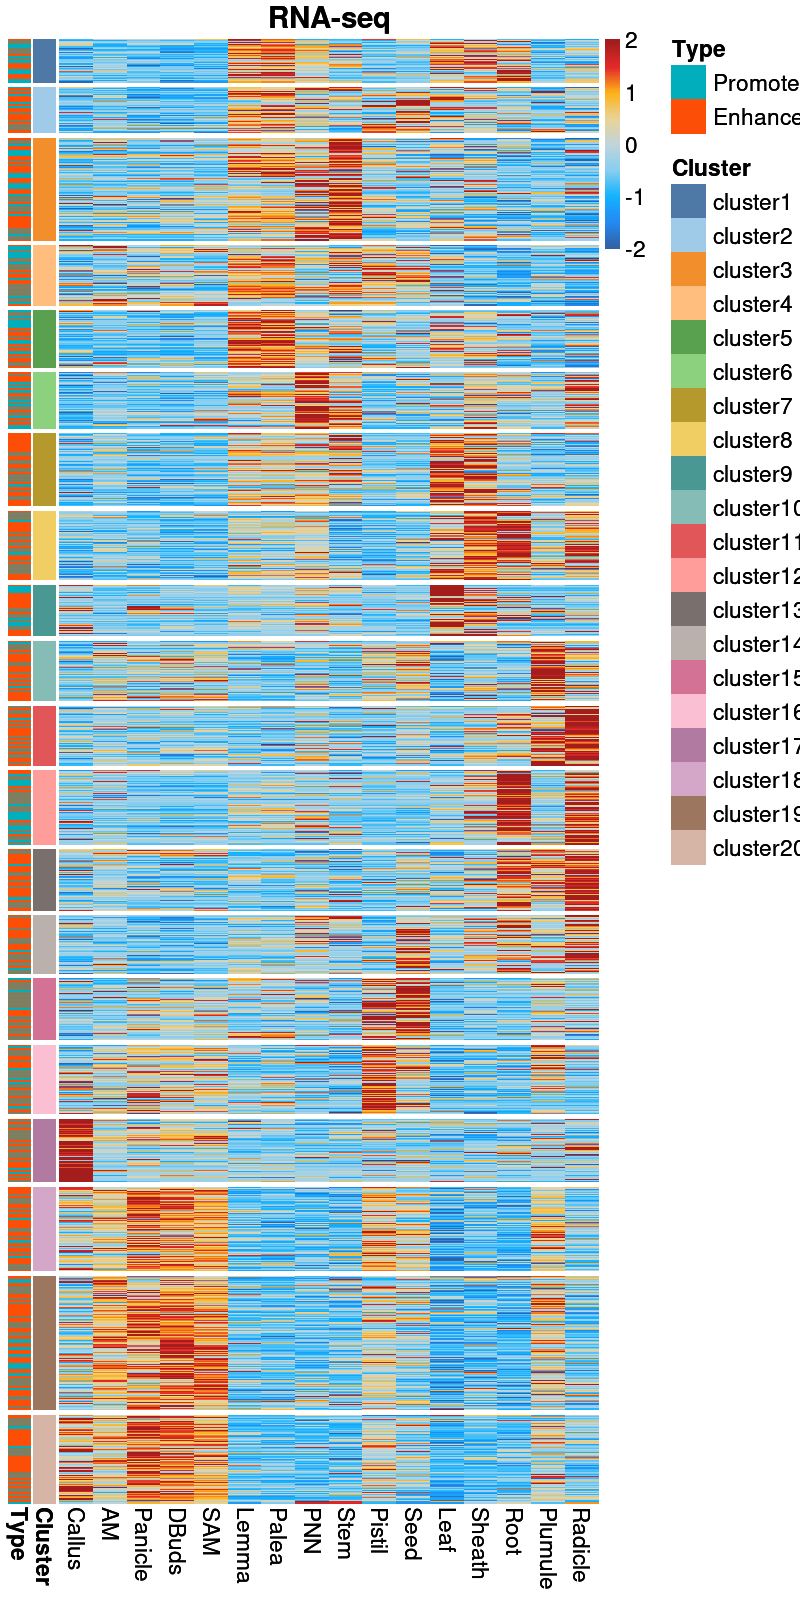

In [92]:
p10 <- pheatmap::pheatmap(rowZscores(as.matrix(merged_df),min = -2, max = 2,limit=T),cluster_row=F,cluster_col=F,
         show_rownames=F,show_colnames=T,border_color=NA,color=paletteContinuous(set = "solarExtra", n = 100),
                   main ="RNA-seq",gaps_row = cumsum(as.numeric(table(group$Cluster)))[1:19],fontsize_col =16,fontsize =16,annotation_colors =gcol, annotation_row = group)
p10

# Cluster GO Enrichment  Analysis

In [96]:
library(org.Osativa.eg.db)
library(ChIPseeker)
library(clusterProfiler)
library(GenomicFeatures)

gff_file <- "~/genome/oryza_sativa.gtf"
txdb <- makeTxDbFromGFF(gff_file)

peak <- readPeakFile("/public/workspace/zhutao/encode/figure/fig3/tissue_sp_peak2gene/peak_final_for_anno.bed")
peakAnno <- annotatePeak(peak, tssRegion=c(-3000, 3000),
                         TxDb=txdb, annoDb="org.Osativa.eg.db")
df <- peakAnno@annoStat
df$Feature <- gsub("1st Exon","Exon",df$Feature)
df$Feature <- gsub("Other Exon","Exon",df$Feature)
df$Feature <- gsub("1st Intron","Intron",df$Feature)
df$Feature <- gsub("Other Intron","Intron",df$Feature)
df$Feature <- gsub("Downstream (<=300)","Downstream (<=300 bp)",df$Feature)
sp_peak <- aggregate(df$Frequency, by=list(Category=df$Feature), FUN=sum)
sp_peak$group <- "Specific peak"
sp_peak

Import genomic features from the file as a GRanges object ... 
OK

Prepare the 'metadata' data frame ... 
OK

Make the TxDb object ... 
OK



>> preparing features information...		 2023-04-14 08:56:58 PM 
>> identifying nearest features...		 2023-04-14 08:56:58 PM 
>> calculating distance from peak to TSS...	 2023-04-14 08:56:59 PM 
>> assigning genomic annotation...		 2023-04-14 08:56:59 PM 
>> adding gene annotation...			 2023-04-14 08:57:04 PM 


Warning message in annotatePeak(peak, tssRegion = c(-3000, 3000), TxDb = txdb, annoDb = "org.Osativa.eg.db"):
“Unknown ID type, gene annotation will not be added...”


>> assigning chromosome lengths			 2023-04-14 08:57:04 PM 
>> done...					 2023-04-14 08:57:04 PM 


Category,x,group
<chr>,<dbl>,<chr>
3' UTR,2.26512227,Specific peak
5' UTR,0.02574003,Specific peak
Distal Intergenic,28.91462891,Specific peak
Downstream (<=300),3.72372372,Specific peak
Exon,1.20120120,Specific peak
Intron,1.29558130,Specific peak
Promoter (<=1kb),33.96825397,Specific peak
Promoter (1-2kb),16.79107679,Specific peak
Promoter (2-3kb),11.81467181,Specific peak


In [97]:
library(org.Osativa.eg.db)
library(ChIPseeker)
library(clusterProfiler)
library(GenomicFeatures)

gff_file <- "~/genome/oryza_sativa.gtf"
txdb <- makeTxDbFromGFF(gff_file)

peak <- readPeakFile("/public/workspace/zhutao/encode/figure/fig3/tissue_sp_peak2gene/NIP_all_peaks_for_anno.bed")
peakAnno <- annotatePeak(peak, tssRegion=c(-3000, 3000),
                         TxDb=txdb, annoDb="org.Osativa.eg.db")
df <- peakAnno@annoStat
df$Feature <- gsub("1st Exon","Exon",df$Feature)
df$Feature <- gsub("Other Exon","Exon",df$Feature)
df$Feature <- gsub("1st Intron","Intron",df$Feature)
df$Feature <- gsub("Other Intron","Intron",df$Feature)
df$Feature <- gsub("Downstream (<=300)","Downstream (<=300 bp)",df$Feature)
all <- aggregate(df$Frequency, by=list(Category=df$Feature), FUN=sum)
all$group <- "All peaks"
all

Import genomic features from the file as a GRanges object ... 
OK

Prepare the 'metadata' data frame ... 
OK

Make the TxDb object ... 
OK



>> preparing features information...		 2023-04-14 08:57:19 PM 
>> identifying nearest features...		 2023-04-14 08:57:20 PM 
>> calculating distance from peak to TSS...	 2023-04-14 08:57:22 PM 
>> assigning genomic annotation...		 2023-04-14 08:57:22 PM 
>> adding gene annotation...			 2023-04-14 08:57:29 PM 


Warning message in annotatePeak(peak, tssRegion = c(-3000, 3000), TxDb = txdb, annoDb = "org.Osativa.eg.db"):
“Unknown ID type, gene annotation will not be added...”


>> assigning chromosome lengths			 2023-04-14 08:57:29 PM 
>> done...					 2023-04-14 08:57:29 PM 


Category,x,group
<chr>,<dbl>,<chr>
3' UTR,1.63641493,All peaks
5' UTR,0.02403419,All peaks
Distal Intergenic,27.31224594,All peaks
Downstream (<=300),3.79635725,All peaks
Exon,0.86523088,All peaks
Intron,1.00107631,All peaks
Promoter (<=1kb),41.31686469,All peaks
Promoter (1-2kb),13.84996395,All peaks
Promoter (2-3kb),10.19781184,All peaks


In [98]:
library(org.Osativa.eg.db)
library(ChIPseeker)
library(clusterProfiler)
library(GenomicFeatures)

gff_file <- "~/genome/oryza_sativa.gtf"
txdb <- makeTxDbFromGFF(gff_file)

peak <- readPeakFile("/public/workspace/zhutao/encode/figure/fig3/tissue_sp_peak2gene/Constitutive_peaks_for_anno.bed")
peakAnno <- annotatePeak(peak, tssRegion=c(-3000, 3000),
                         TxDb=txdb, annoDb="org.Osativa.eg.db")
df <- peakAnno@annoStat
df$Feature <- gsub("1st Exon","Exon",df$Feature)
df$Feature <- gsub("Other Exon","Exon",df$Feature)
df$Feature <- gsub("1st Intron","Intron",df$Feature)
df$Feature <- gsub("Other Intron","Intron",df$Feature)
df$Feature <- gsub("Downstream (<=300)","Downstream (<=300 bp)",df$Feature)
constitutive <- aggregate(df$Frequency, by=list(Category=df$Feature), FUN=sum)
constitutive$group <- "Constitutive peaks"

Import genomic features from the file as a GRanges object ... 
OK

Prepare the 'metadata' data frame ... 
OK

Make the TxDb object ... 
OK



>> preparing features information...		 2023-04-14 08:57:47 PM 
>> identifying nearest features...		 2023-04-14 08:57:48 PM 
>> calculating distance from peak to TSS...	 2023-04-14 08:57:49 PM 
>> assigning genomic annotation...		 2023-04-14 08:57:49 PM 
>> adding gene annotation...			 2023-04-14 08:57:54 PM 


Warning message in annotatePeak(peak, tssRegion = c(-3000, 3000), TxDb = txdb, annoDb = "org.Osativa.eg.db"):
“Unknown ID type, gene annotation will not be added...”


>> assigning chromosome lengths			 2023-04-14 08:57:54 PM 
>> done...					 2023-04-14 08:57:54 PM 


In [101]:
anno_res <- rbind(sp_peak, all, constitutive)
anno_res$Category <- factor(anno_res$Category, levels=c("Promoter (<=1kb)","Promoter (1-2kb)","Promoter (2-3kb)","5' UTR","3' UTR","Exon","Intron","Downstream (<=300)","Distal Intergenic"))
head(anno_res)

,Category,x,group
,<fct>,<dbl>,<chr>
1,3' UTR,2.26512227,Specific peak
2,5' UTR,0.02574003,Specific peak
3,Distal Intergenic,28.91462891,Specific peak
4,Downstream (<=300),3.72372372,Specific peak
5,Exon,1.20120120,Specific peak
6,Intron,1.29558130,Specific peak


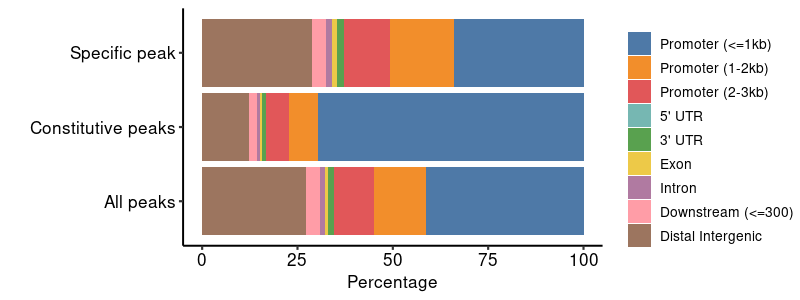

In [102]:
library(plyr)
# Sort by dose and supp
df_sorted <- arrange(anno_res, group, Category) 
df_cumsum <- ddply(df_sorted, "group",
                   transform, label_ypos=cumsum(x)/2)

options(repr.plot.width = 8, repr.plot.height = 3, repr.plot.res = 100)
p12 <- ggplot(anno_res, aes(fill=Category, y=group, x=x))+
scale_fill_manual(values=paletteer_d("ggthemes::Tableau_10"))+
geom_bar(position="stack", stat="identity")+
theme_pubr()+labs(x = "Percentage", y = '')+guides(fill=guide_legend(title=""))+ theme(legend.position='right')
p12
#geom_text(aes(y=label_ypos, label=round(x,2)), vjust=0, 
#            color="white", size=3.5)